In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!ls

In [7]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras import Input
import os
from tensorflow.image import per_image_standardization

In [8]:
from PIL import Image
from IPython.display import display
import seaborn as sns

In [9]:
data_dir = '/kaggle/input/extended-yale-dataset-b/ExtendedYaleB/'

In [10]:
def dataread(folder_location, train_percentage):
    '''
    This dataread function takes the folder location and converts the files
    inside it to tensors (after resizing it). the tensor is of 4 dimensions 
    where 
    1st- number of files
    2nd and 3rd pixel size
    '''
    train_data = []
    train_pose = []
    train_azimuthal = []
    train_elevation = []
    
    test_data = []
    test_pose = []
    test_azimuthal = []
    test_elevation = []
    
    #val_data = []
    #val_pose = []
    #val_azimuthal = []
    #val_elevation = []
    
    threshold = train_percentage / 100.0
    reduced_size = (160,160)
    for sub_dir in sorted(os.listdir(folder_location)):
        for file in os.listdir(folder_location + sub_dir + "/"):
            x = file.split(".")
            if len(x) < 2:
                pass
            elif x[1] == "pgm":
                curr = np.random.rand()
                name = folder_location + sub_dir + "/" + file
                pose = int(x[0].split("_P")[1][0:2])
                azi_ele = x[0].split("A")[1].split("E")
                
                if (azi_ele == ['mbient'] or pose > 8):
                    pass
                
                elif curr <= threshold:
                    image = cv2.resize(cv2.imread(name),reduced_size)
                    
                    xxx = np.random.rand()
                    if xxx < 0.0001: 
                        data = Image.fromarray(image)
                        display(data)
                        
                    image = image.transpose(2, 0, 1)
                    #image = per_image_standardization(image)
                    train_data.append(image)
                    x1 = int(azi_ele[0]) / 180.0
                    x2 = int(azi_ele[1]) / 90.0
                    train_azimuthal.append(x1)
                    train_elevation.append(x2)
                    train_pose.append(pose)
                    
                elif np.random.rand() > 0.5:
                    image = cv2.resize(cv2.imread(name),reduced_size)
                    image = image.transpose(2, 0, 1)
                    test_data.append(image)
                    x1 = int(azi_ele[0]) / 180.0
                    x2 = int(azi_ele[1]) / 90.0
                    test_azimuthal.append(x1)
                    test_elevation.append(x2)
                    test_pose.append(pose)
                '''    
                else: 
                    image = cv2.resize(cv2.imread(name),reduced_size)
                    image = image.transpose(2, 0, 1)
                    #image = per_image_standardization(image)
                    val_data.append(image)
                    x1 = int(azi_ele[0]) / 180.0
                    x2 = int(azi_ele[1]) / 90.0
                    val_azimuthal.append(x1)
                    val_elevation.append(x2)
                    val_pose.append(pose) '''
                    
    #val_data = np.array(val_data)
    #l_val = len(val_azimuthal)
    #val_azimuthal = np.array(val_azimuthal).reshape((l_val,1))
    #val_elevation = np.array(val_elevation).reshape((l_val,1))
    #val_pose = np.array(val_pose).reshape((l_val,1))
    
    train_data = np.array(train_data)
    l_train = len(train_azimuthal)
    train_azimuthal = np.array(train_azimuthal).reshape((l_train,1))
    train_elevation = np.array(train_elevation).reshape((l_train,1))
    train_pose = np.array(train_pose).reshape((l_train,1))
    
    test_data = np.array(test_data)
    l_test = len(test_azimuthal)
    test_azimuthal = np.array(test_azimuthal).reshape((l_test,1))
    test_elevation = np.array(test_elevation).reshape((l_test,1))
    test_pose = np.array(test_pose).reshape((l_test,1))
    
    # val_data,val_azimuthal,val_elevation,val_pose,
    return (
        train_data,train_azimuthal,train_elevation,train_pose,
        
        test_data,test_azimuthal,test_elevation,test_pose
    )

In [11]:
train_percentage = 90

# The train+val data can be loaded via 
output = dataread(data_dir, train_percentage)
train_data,train_azimuthal,train_elevation,train_pose, test_data,test_azimuthal,test_elevation,test_pose = output

print("train_data ", train_data.shape)
#print("validation_data", val_data.shape)
print("test_data ", test_data.shape)

train_data  (14467, 3, 160, 160)
test_data  (800, 3, 160, 160)


In [12]:
train_data = train_data.transpose(0,2,3,1)
test_data = test_data.transpose(0,2,3,1)
#val_data = val_data.transpose(0,2,3,1)
print("train_data ", train_data.shape)
print("test_data ", test_data.shape)
#print("validation_data", val_data.shape)

train_data  (14467, 160, 160, 3)
test_data  (800, 160, 160, 3)


In [13]:
## Classifying the data, based on the poses they belong to
## Solving the Head Pose Classification Problem
batch_size = 32
epochs = 5 # higher epochs are overfitting the data 
data_augmentation = True
num_classes = 9

n = 3 
depth = n * 6 + 2

# Load appropriate features of the data for classification
x_train = train_data
y_train = train_pose 
x_test = test_data
y_test = test_pose
  
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train_mean = np.mean(x_train, axis = 0)
x_train -= x_train_mean
x_test -= x_train_mean

# Print Training and Test Samples 
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
  
# one-hot encoding the labels of the data
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (14467, 160, 160, 3)
14467 train samples
800 test samples
y_train shape: (14467, 1)


In [14]:
def lr_schedule(epoch):
    """
    Makes sure, the longer we keep training, the smaller the 
    learning rate has to be for improvements
    """
    lr = 1.2e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [24]:
# Basic ResNet Building Block
def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu',batch_normalization=True, conv_first=False):
    """
    Building block for the ResNet like architecture
    """
    conv = Conv2D(filters=num_filters, kernel_size=kernel_size,strides=strides,padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [25]:
def resnet(input_shape, depth, num_classes = 9):
    """
    ResNet inspired architecture for our image classification
    """
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)
  
    inputs = Input(shape = input_shape)
    x = resnet_layer(inputs = inputs, num_filters = num_filters_in, conv_first = True)
  
    for stage in range(1):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample
  
            # bottleneck residual unit
            y = resnet_layer(inputs = x,
                             num_filters = num_filters_in,
                             kernel_size = 1,
                             strides = strides,
                             activation = activation,
                             batch_normalization = batch_normalization,
                             conv_first = False)
            y = resnet_layer(inputs = y,
                             num_filters = num_filters_in,
                             conv_first = False)
            y = resnet_layer(inputs = y,
                             num_filters = num_filters_out,
                             kernel_size = 1,
                             conv_first = False)
            if res_block == 0:
                # linear projection residual shortcut connection to match changed dimension
                x = resnet_layer(inputs = x,
                                 num_filters = num_filters_out,
                                 kernel_size = 1,
                                 strides = strides,
                                 activation = None,
                                 batch_normalization = False)
            x = keras.layers.add([x, y])
  
        num_filters_in = num_filters_out
  
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size = 8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation ='softmax',
                    kernel_initializer ='he_normal')(y)
  
    # Instantiate model.
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [26]:
model = resnet(input_shape=input_shape, depth=depth)
model.compile(loss ='categorical_crossentropy',
              optimizer = Adam(learning_rate = lr_schedule(0)),
              metrics =['accuracy'])
model.summary()

Learning rate:  0.0012
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 160, 160, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 160, 160, 16) 64          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 160, 160, 16) 0           batch_normalization_7[0][0]      
_____________________________________________________________________

In [27]:
checkpoint_path = "/kaggle/working/trained_model.ckpt"
cehckpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True,
                                             verbose=1)

In [28]:
## Training the Model and checking its accuracy
if not data_augmentation:
    print('Simple Model Fit, No Data Augmentation')
    model.fit(x_train, y_train,
              batch_size = batch_size,
              epochs = epochs,
              validation_data =(x_test, y_test),
              shuffle = True,
              callbacks = [cp_callback])
else:
    print('Additional, Real-Time Data Augmentation Happening')
    datagen = ImageDataGenerator(
        preprocessing_function = per_image_standardization, #standardization of images
        data_format = None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split = 0.2) # 20% is being used for validation purpose
  
    datagen.fit(x_train)
  
    # Fit the model on the batches generated by datagen.flow().
    history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size),
                        validation_data =(x_test, y_test),
                        epochs = epochs, verbose = 1, workers = 4,
                        callbacks=[cp_callback])
  
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose = 1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Additional, Real-Time Data Augmentation Happening
Epoch 1/5
453/453 [==============================] - 62s 135ms/step - loss: 2.4809 - accuracy: 0.3875 - val_loss: 1.7967 - val_accuracy: 0.3900

Epoch 00001: val_loss improved from inf to 1.79673, saving model to /kaggle/working/trained_model.ckpt
Epoch 2/5
453/453 [==============================] - 61s 133ms/step - loss: 0.5615 - accuracy: 0.8333 - val_loss: 1.4940 - val_accuracy: 0.6012

Epoch 00002: val_loss improved from 1.79673 to 1.49396, saving model to /kaggle/working/trained_model.ckpt
Epoch 3/5
453/453 [==============================] - 60s 132ms/step - loss: 0.2711 - accuracy: 0.9284 - val_loss: 1.4138 - val_accuracy: 0.5987

Epoch 00003: val_loss improved from 1.49396 to 1.41384, saving model to /kaggle/working/trained_model.ckpt
Epoch 4/5
453/453 [==============================] - 60s 133ms/step - loss: 0.1757 - accuracy: 0.9602 - val_loss: 1.1485 - val_accuracy: 0.6850

Epoch 00004: val_loss improved from 1.41384 to 1.1484

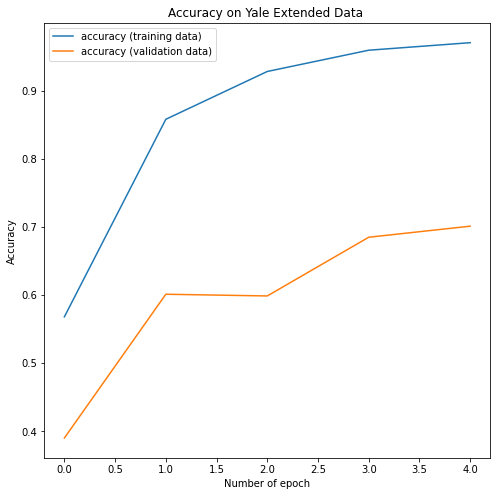

In [40]:
figure = plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], label='accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='accuracy (validation data)')
plt.title('Accuracy on Yale Extended Data ')
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.legend(loc="upper left")
plt.show()

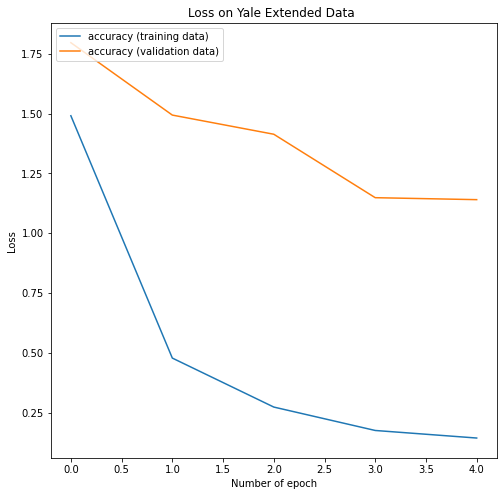

In [42]:
figure = plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], label='accuracy (training data)')
plt.plot(history.history['val_loss'], label='accuracy (validation data)')
plt.title('Loss on Yale Extended Data ')
plt.ylabel('Loss')
plt.xlabel('Number of epoch')
plt.legend(loc="upper left")
plt.show()

In [30]:
predictions = model.predict(x_test)
pred_length = predictions.shape[0]
for i in range(pred_length):
    predictions[i] = (predictions[i] >= max(predictions[i])).astype(int)

In [31]:
y_true = []
y_pred = []
for i in range(pred_length):
    y_pred.append(np.argmax(predictions[i]))
    y_true.append(np.argmax(y_test[i]))
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [32]:
confusion_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred)

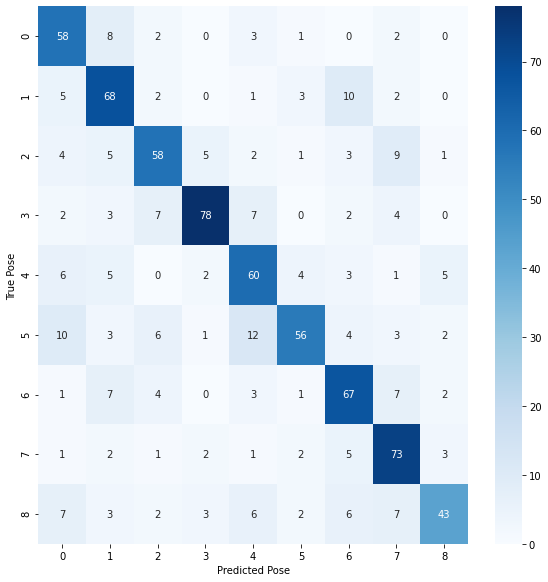

In [33]:
figure = plt.figure(figsize=(8,8))
sns.heatmap(confusion_mat, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True Pose')
plt.xlabel('Predicted Pose')
plt.show()

Correct predictions
Pose:  0


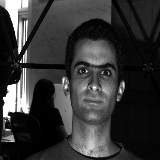

Pose:  1


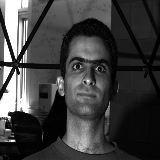

Pose:  2


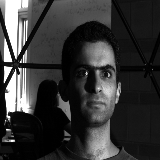

Pose:  3


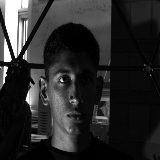

Pose:  4


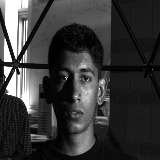

Pose:  5


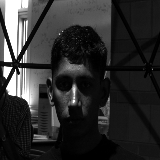

Pose:  6


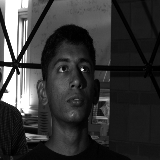

Pose:  7


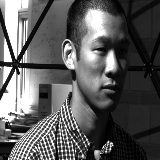

Pose:  8


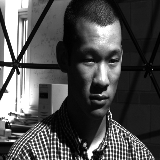

In [34]:
print("Correct predictions")
curr_pose = 0
while curr_pose < 9:
    for idx in range(0, len(y_test)):
        if y_true[idx] == curr_pose and y_pred[idx] == curr_pose:
            data = Image.fromarray(test_data[idx])
            print("Pose: ", curr_pose)
            display(data)
            curr_pose += 1

(5, 4)


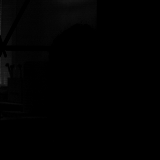

(5, 4)


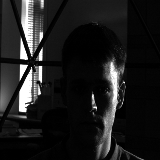

(5, 4)


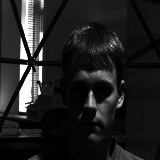

(5, 4)


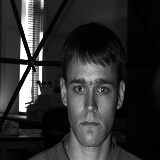

(5, 4)


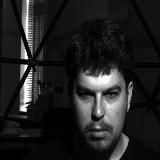

(5, 4)


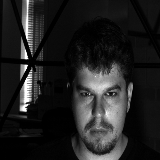

(5, 4)


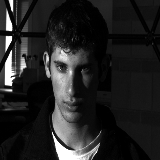

(5, 4)


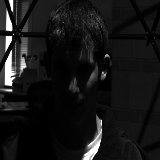

(5, 4)


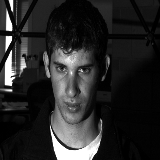

(5, 4)


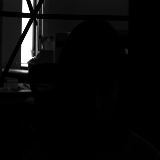

(5, 4)


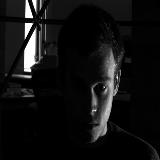

(5, 4)


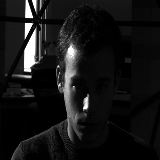

In [35]:
for i in range(len(y_true)):
    if (y_true[i], y_pred[i]) == (5,4):
        print((y_true[i], y_pred[i]))
        data = Image.fromarray(test_data[i])
        display(data)

(5, 0)


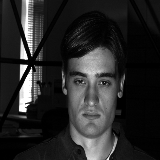

(5, 0)


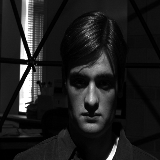

(5, 0)


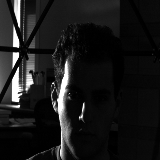

(5, 0)


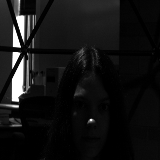

(5, 0)


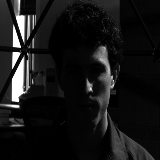

(5, 0)


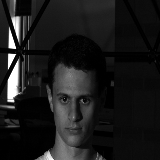

(5, 0)


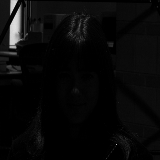

(5, 0)


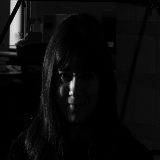

(5, 0)


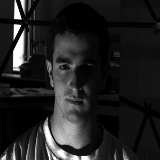

(5, 0)


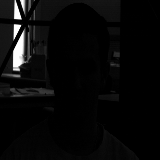

In [36]:
for i in range(len(y_true)):
    if (y_true[i], y_pred[i]) == (5,0):
        print((y_true[i], y_pred[i]))
        data = Image.fromarray(test_data[i])
        display(data)

(6, 1)


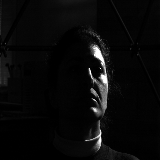

(6, 1)


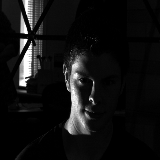

(6, 1)


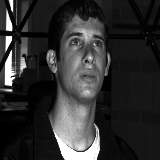

(6, 1)


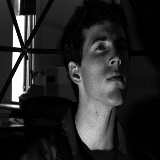

(6, 1)


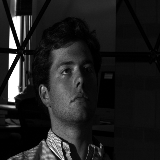

(6, 1)


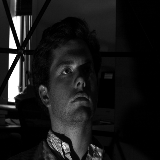

(6, 1)


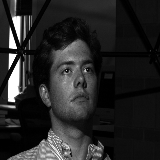

In [37]:
for i in range(len(y_true)):
    if (y_true[i], y_pred[i]) == (6,1):
        print((y_true[i], y_pred[i]))
        data = Image.fromarray(test_data[i])
        display(data)

In [38]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
img_path = data_dir + 'yaleB11/yaleB11_P00A-015E+20.pgm' #dog
img_path

'/kaggle/input/extended-yale-dataset-b/ExtendedYaleB/yaleB11/yaleB11_P00A-015E+20.pgm'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


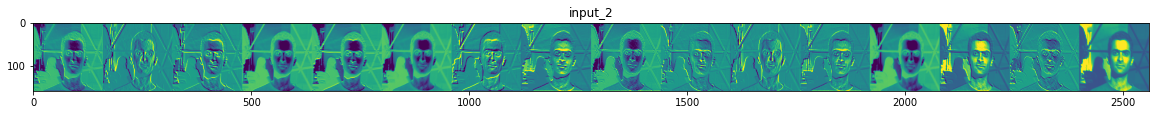

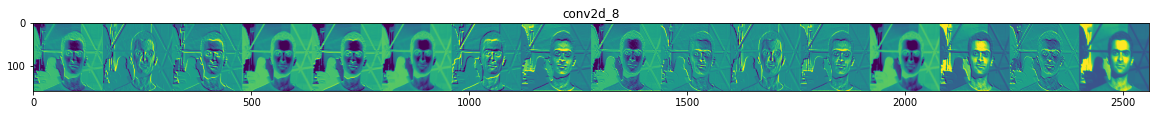

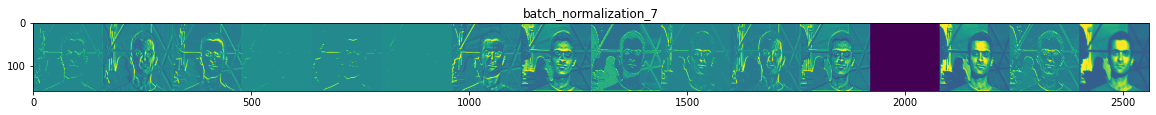

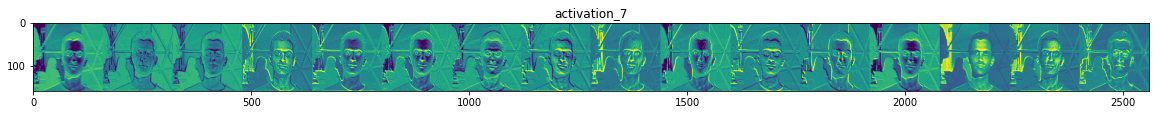

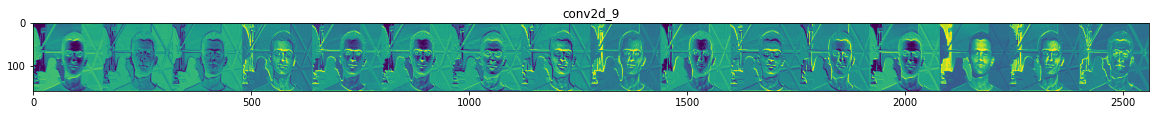

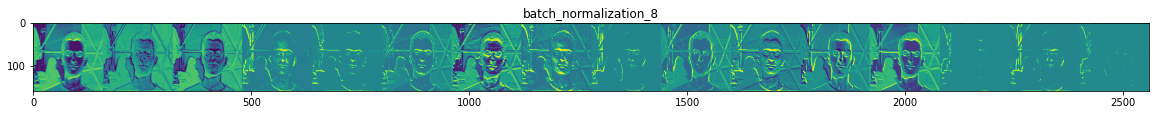

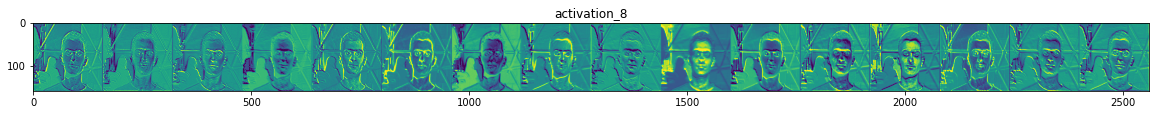

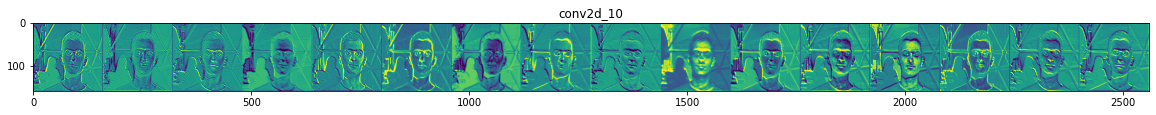

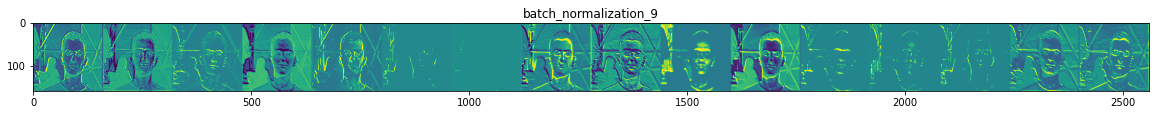

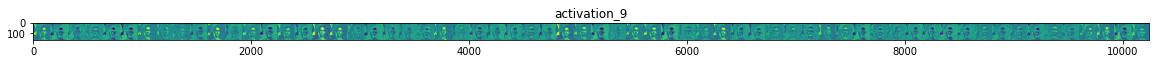

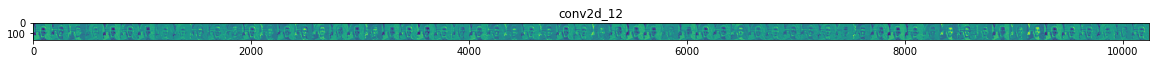

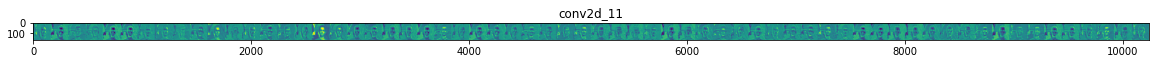

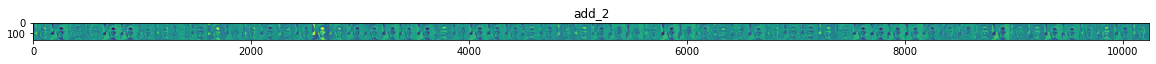

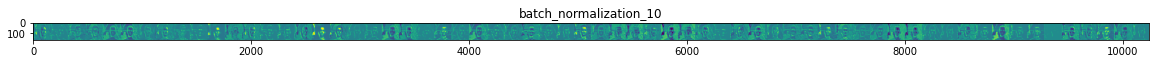

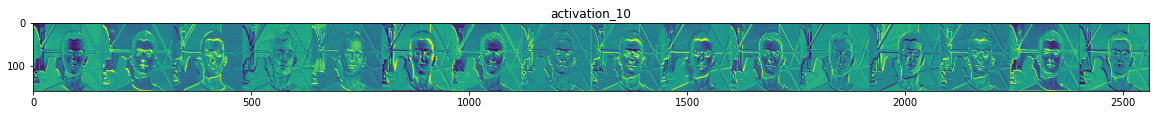

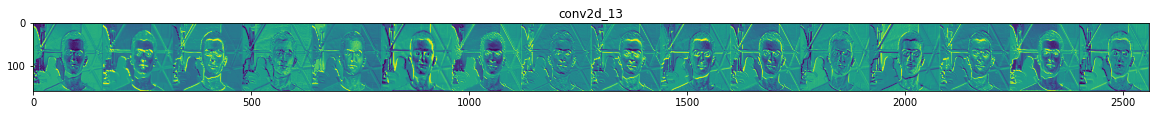

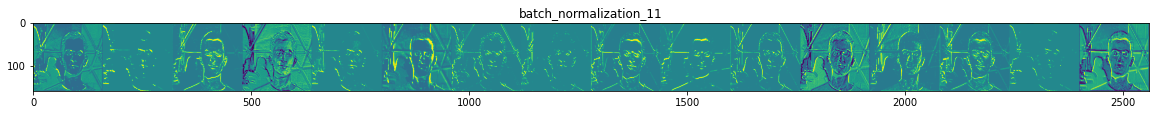

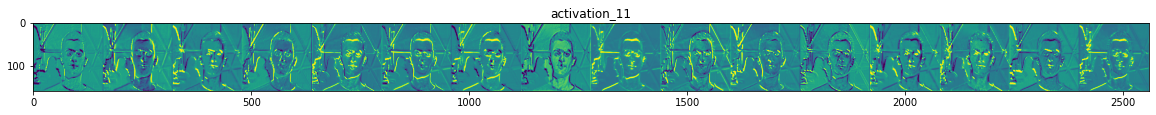

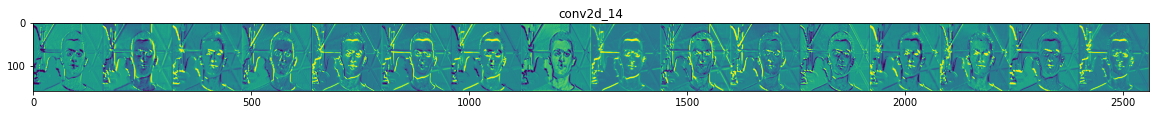

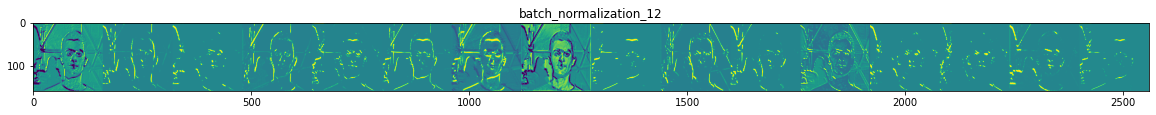

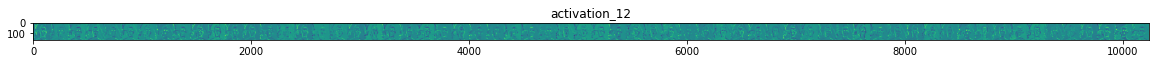

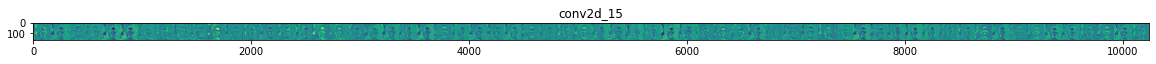

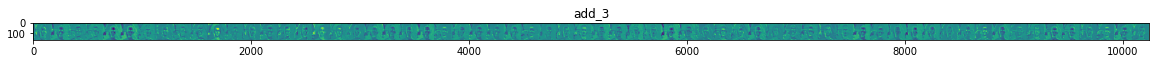

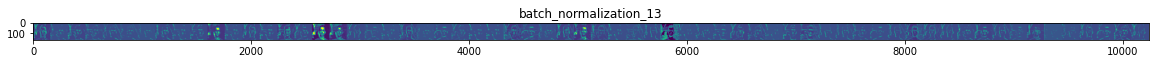

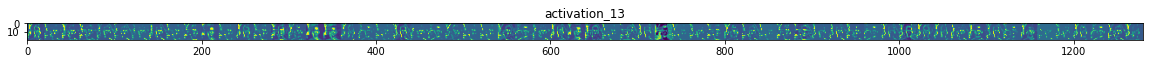

In [39]:
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

img = load_img(img_path, target_size=(160, 160))
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
x /= 255.0
successive_feature_maps = visualization_model.predict(x)


layer_names = [layer.name for layer in model.layers] # retrieving layers of my neural network
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Ignore the Dense layers 
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    display_grid = np.zeros((size, size * n_features)) # making it looking like a image 
    
    # Postprocessing to make it look like an image
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )